In [1]:
import datetime 
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, pandas_dataframe_to_unit_arrays
import matplotlib.pyplot as plt
import metpy.plots as plots
import metpy.calc as mpcalc
import numpy as np
from matplotlib.pyplot import imread

%matplotlib inline

In [2]:
current_year = datetime.date.today().year
current_month = datetime.date.today().month
current_day = datetime.date.today().day
#datetime.date.today()

current_datetime = datetime.datetime(current_year, current_month, current_day, 12)
#current_datetime = datetime(2021, 7, 26, 12) #sept-10-2017 @ 0000z

Dias_de_la_semana = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
tday = current_datetime.weekday()
Dia_de_la_semana = Dias_de_la_semana[tday]

Meses_del_Ano = ['', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre',
                     'Octubre', 'Noviembre', 'Diciembre']
Mes_del_Ano = Meses_del_Ano[current_month]

fecha_y_hora = f'{Dia_de_la_semana} {current_day} de {Mes_del_Ano} de {current_year} - 8:00 a.m.'

In [3]:
station = '78486'

df = WyomingUpperAir.request_data(current_datetime, station)
d  = pandas_dataframe_to_unit_arrays(df)

mandatory_levels = [1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100]

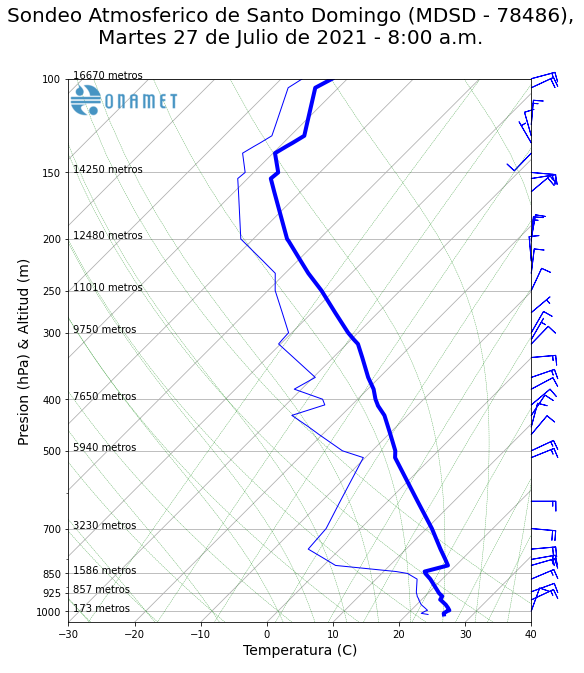

In [4]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig, rotation = 45)

skew.plot(d['pressure'], d['temperature'], 'b', linewidth = 4)
skew.plot(d['pressure'], d['dewpoint'], 'b', linewidth = 1)

skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-30, 40)

fig.suptitle(f'Sondeo Atmosferico de Santo Domingo (MDSD - 78486),\n{fecha_y_hora}', fontsize = 20)
#fig.suptitle('Domingo 25 de julio de 2021 - 8:00 a.m.', fontsize = 20, y=0.)
plt.xlabel('Temperatura (C)', fontsize = 14)
plt.ylabel('Presion (hPa) & Altitud (m)', fontsize = 14)
plt.yticks(ticks=mandatory_levels)

interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
skew.plot_barbs(d['pressure'][idx], d['u_wind'][idx], d['v_wind'][idx], barbcolor = 'blue', sizes = 
               dict(width = 0.01))

skew.plot_dry_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)
skew.plot_moist_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)

p_space = np.linspace(100, max(skew.ax.get_ylim())) * units.mbar
skew.plot_mixing_lines(pressure = p_space, colors = 'green', linewidth = 0.4, alpha = 0.7)
#skew.plot_mixing_lines(colors = 'green', linewidth = 0.4, alpha = 0.7)

logo = imread('onamet-110X32.png')
fig.figimage(logo, 70, 557, zorder=100)

#interval = [k for k in range(1000, 0, -100)] * units.hPa
interval = mandatory_levels * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
for p, t, h  in zip(d['pressure'][idx], d['temperature'][idx], d['height'][idx]):
    if p >= 100 * units.hPa:
        skew.ax.text(0.01, p, f'{round(h.m, 0)} metros', fontsize=10, 
                     transform = skew.ax.get_yaxis_transform(which='tick2'))

In [5]:
# # skew.ax.axhline(lcl_pressure)




# skew.ax.axvline(x=0, ymin=0, ymax=0.28, color='c', linestyle='--', linewidth=2)
# lcl_pressure, lcl_temperature = mpcalc.lcl(d['pressure'][0], d['temperature'][0], d['dewpoint'][0])
# skew.plot(lcl_pressure, lcl_temperature, color = 'black', marker = 'o', markerfacecolor='red')

In [6]:
#https://stackoverflow.com/questions/65985185/cape-cin-returning-incorrect-values

# Calculate the mixed parcel--need to pass pressure as an additional variable to "mix" so that we get
# an appropriate "average pressure" to use as the mixed parcel

parcel_temperature, parcel_dewpoint, mixed_pressure = mpcalc.mixed_layer(d['pressure'], d['temperature'],
                                                           d['dewpoint'], d['pressure'],
                                                           height=d['height'], depth=500 * units.m)

# Replace the lowest part of the sounding with the mixed value
pressure_mixed = np.concatenate([np.atleast_1d(mixed_pressure), d['pressure'][d['pressure'] < mixed_pressure]])
temperature_mixed = np.concatenate([np.atleast_1d(parcel_temperature), 
                                    d['temperature'][d['pressure'] < mixed_pressure]])
dewpoint_mixed = np.concatenate([np.atleast_1d(parcel_dewpoint), d['dewpoint'][d['pressure'] < mixed_pressure]])

# Calculate the parcel profile, including the LCL--this interpolates the sounding to the level of the LCL
# as well, so that the profile and all variables have the same points

parcel_path_LCL = mpcalc.parcel_profile(pressure_mixed, parcel_temperature, parcel_dewpoint)
skew.plot(pressure_mixed, parcel_path_LCL, color = 'k', linewidth = 0.4)

mask = pressure_mixed >= 200 * units.hPa
skew.shade_cape(pressure_mixed, temperature_mixed, parcel_path_LCL)
skew.shade_cin(pressure_mixed[mask], temperature_mixed[mask], parcel_path_LCL[mask])



In [7]:
lcl_pressure, lcl_temperature = mpcalc.lcl(mixed_pressure, parcel_temperature, parcel_dewpoint)
lfc_pressure, lfc_temperature = mpcalc.lfc(pressure_mixed, temperature_mixed, dewpoint_mixed, which = 'bottom')
el_pressure, el_temperature = mpcalc.el(pressure_mixed, temperature_mixed, dewpoint_mixed)

cape, cin = mpcalc.cape_cin(pressure_mixed, temperature_mixed, dewpoint_mixed, parcel_path_LCL)

li = mpcalc.lifted_index(pressure_mixed, temperature_mixed, parcel_path_LCL)

pw = mpcalc.precipitable_water(d['pressure'], d['dewpoint'])



In [38]:
idx = np.where(d['pressure'] == 850 * units.hPa)
idx = idx[0][0]
t_850 = d['temperature'][idx]
td_850 = d['dewpoint'][idx]
ws_850 = d['speed'][idx]
wd_850 = d['speed'][idx]
pressure_set_from_850  = d['pressure'][idx:]
parcel_path_850 = mpcalc.parcel_profile(pressure_set_from_850, d['temperature'][idx], d['dewpoint'][idx])

idx = np.where(d['pressure'] == 500 * units.hPa)
idx = idx[0][0]
t_500 = d['temperature'][idx]
tp_500 = parcel_path_LCL[idx].to(units.degC)
ws_500 = d['speed'][idx]
wd_500 = d['speed'][idx]


idx = np.where(d['pressure'] == 700 * units.hPa)
idx = idx[0][0]
t_700 = d['temperature'][idx]
td_700 = d['dewpoint'][idx]

idx = np.where(pressure_set_from_850 == 500 * units.hPa)
idx = idx[0][0]
tp_500_850 = parcel_path_850[idx].to(units.degC)


kinx = ( t_850 - t_500 ) + td_850 - ( t_700 - td_700 ) 
ctot = td_850 - t_500 
vtot = t_850 - t_500 
totl = ( t_850 - t_500 ) + ( td_850 - t_500 )
show = t_500 - tp_500_850


#######SWET = 12 * TD850 + 20 * TERM2 + 2 * SKT850 + SKT500 + SHEAR 
a = 0
wd_500_850 = wd_500.m - wd_850.m
if 130 <= wd_850.m <= 250 and 210 <= wd_500.m <= 310 and  wd_500_850 > 0 and ws_500.m >= 15 and ws_850.m >= 15:
    a = 1
    
b=0
if totl.m > 49:
    b = 1
    
swet = 12*td_850.m + 20 * b * totl.m + 2*ws_850.m + ws_500.m + 125 * a *(float(np.sin(wd_500.m - wd_850.m)) + 0.2)


#######Frezing Level
freezing_temperature = 0 * units.degC
zero_temp_index = np.abs(d['temperature'] - freezing_temperature).argmin()
freezing_level  = d['height'][zero_temp_index]
closest_to_zero = np.abs(d['temperature'] - freezing_temperature)[zero_temp_index]
if closest_to_zero.m > 1 or closest_to_zero.m < -1:
    freezing_level = 9999 * units.degC


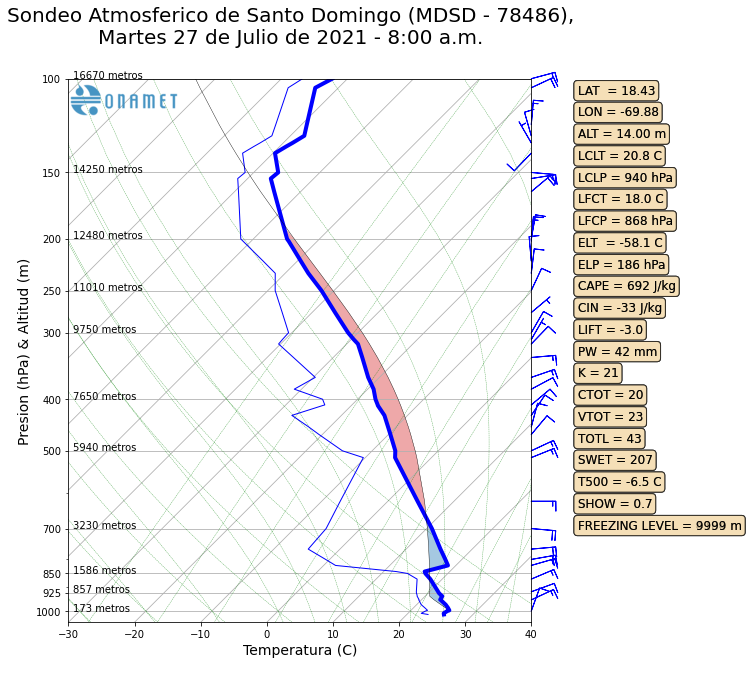

In [39]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

txts     = [f'LAT  = 18.43', f'LON = -69.88', f'ALT = 14.00 m',            
            f'LCLT = {round(lcl_temperature.m, 1)} C', f'LCLP = {int(lcl_pressure.m)} hPa', 
            f'LFCT = {round(lfc_temperature.m, 1)} C', f'LFCP = {int(lfc_pressure.m)} hPa',
            f'ELT  = {round(el_temperature.m, 1)} C', f'ELP = {int(el_pressure.m)} hPa',
            f'CAPE = {int(cape.m)} J/kg', f'CIN = {int(cin.m)} J/kg',
            f'LIFT = {round(float(li.m), 1)}', f'PW = {int(pw.m)} mm', f'K = {int(kinx.m)}',
            f'CTOT = {int(ctot.m)}', f'VTOT = {int(vtot.m)}', f'TOTL = {int(totl.m)}',
            f'SWET = {int(swet)}', f'T500 = {round(t_500.m, 1)} C', f'SHOW = {round(show.m, 1)}',
            f'FREEZING LEVEL = {int(freezing_level.m)} m']

xtxt = 1.1
ytxt = 0.99

for txt in txts:
    skew.ax.text(xtxt, ytxt, txt, transform=skew.ax.transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)
    ytxt = ytxt - 0.04
fig

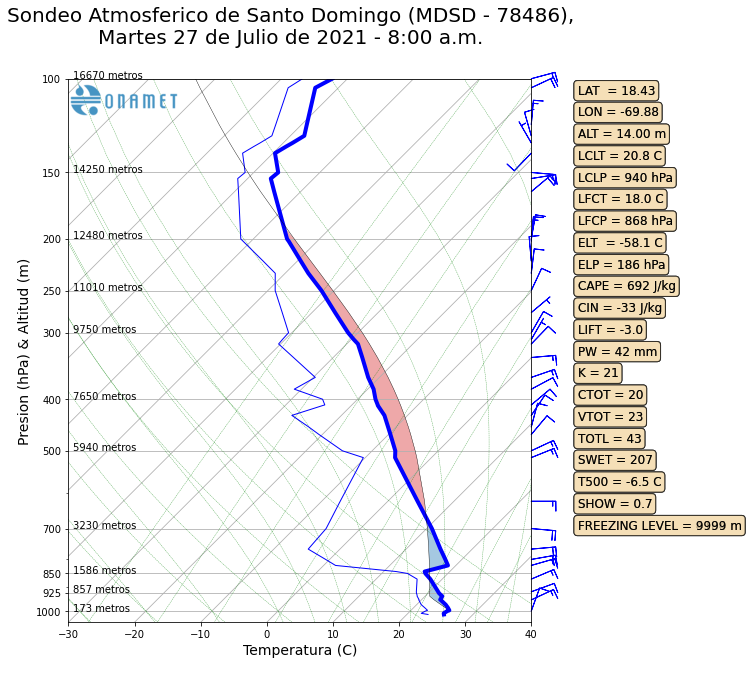

In [42]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.suptitle(f'Sondeo Atmosferico de Santo Domingo (MDSD - 78486),\n{fecha_y_hora}', fontsize = 20, bbox=props)
fig